In [13]:
import os
import copy
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm import tqdm
from scipy.special import logsumexp
from shapely.geometry import shape
from scipy.optimize import minimize

%matplotlib inline

# Import data

In [2]:
# Select dataset
dataset = "commuter_ward" #"synthetic", "retail", "commuter_ward", "commuter_borough"
# Select constraint
constrained = "singly"
# Select gamma
gamma = 100

In [3]:
# Import relevant data
origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
initial_destination_sizes = np.loadtxt(f'../data/input/{dataset}/initial_destination_sizes.txt')
cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix.txt')

# Define log sizes
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
# Define normalised cost_matrix
c = cost_matrix/np.sum(cost_matrix)
# Define normalised origin_supply
o = origin_supply/np.sum(origin_supply)

# Define dimensions
N,M = cost_matrix.shape

In [4]:
# Set parameters
alpha = 1.2#1.1
beta = 4.158415841584159
delta = np.min(np.exp(xd))
gamma = 10000
kappa = 1 + delta*M
epsilon = 1

# Define theta
theta = [alpha,beta,delta,gamma,kappa,epsilon]

# Decide on mode (stochastic/deterministic)
if delta == 0:
    mode = 'deterministic'
else:
    mode = 'stochastic'

In [5]:
# Import log-likelihood values
log_likelihood_values = np.loadtxt(f'../data/output/{dataset}/laplace/{constrained}_laplace_analysis_gamma_{str(gamma)}.txt')
# Import log-likelihood search parameters
with open(f'../data/output/{dataset}/laplace/figures/{constrained}_laplace_analysis_gamma_{str(gamma)}_parameters.json') as json_file:
    log_likelihood_value_params = json.load(json_file)

amin = log_likelihood_value_params['amin']
amax = log_likelihood_value_params['amax']
bmin = log_likelihood_value_params['bmin']
bmax = log_likelihood_value_params['bmax']
grid_n = log_likelihood_value_params['grid_size']
alpha = log_likelihood_value_params['fitted_alpha']
beta = log_likelihood_value_params['fitted_beta']

    
alpha_values = np.linspace(amin, amax, grid_n+1)[1:]
beta_values = np.linspace(bmin, bmax, grid_n+1)[1:]
XX, YY = np.meshgrid(alpha_values, beta_values)


# Compute flows and use them to assert model results

In [6]:
# As defined in C function
def _logsumexp(xx):
    _max = xx[0]
    for j in range(M):
        if xx[j] > _max:
            _max = xx[j]

    _sum = 0;
    for j in range(M):
        _sum += np.exp(xx[j] - _max);

    return _max + np.log(_sum)
def pot_value(x,params):
    pot = 1
    a = params[0]
    b = params[1]
    d = params[2]
    g = params[3]
    k = params[4]
    e = params[5]
    a_inv = 1./a
    
    grad = np.zeros(M)
    wksp = np.zeros(M)
    
    utility = 0
    for i in range(N):
        for j in range(M):
            wksp[j] = a*x[j] - b*c[i,j]
        temp = _logsumexp(wksp)

        utility += -e*a_inv*o[i]*temp;
        
        for j in range(M):
            grad[j] += -e*o[i]*np.exp(wksp[j]-temp)
            
    for j in range(M):
        grad[j] += k*np.exp(x[j]) - d
        grad[j] *= g

        
    # Compute cost and additional utilities
    cost = k * np.sum(np.exp(x))
    additional = -d * np.sum(x)

    potential = g*e*(utility+cost+additional)
        
    return potential,grad

def pot_hess(x,params):
    a = params[0]
    b = params[1]
    d = params[2]
    g = params[3]
    k = params[4]
    e = params[5]
        
    hess = np.zeros((N,M))
    wksp = np.zeros(M)

    for i in range(N):
        for j in range(M):
            wksp[j] = a*x[j] - b*c[i,j]
        temp = _logsumexp(wksp)
        
        for j in range(M):
            wksp[j] = np.exp(wksp[j] - temp)
        
        for j in range(M):
            for k in range(j+1,M):
                temp = e*a*o[i]*wksp[j]*wksp[k]
                hess[j,k] += temp
                hess[k,j] += temp
    
        for j in range(M):
            hess[j,j] += e*a*o[i]*wksp[j]*(wksp[j] - 1.)
    
    for j in range(M):
        hess[j,j] += k*np.exp(x[j])
        
    for j in range(M):
        for k in range(M):
            hess[j,k] *= gamma
            
    return hess

def global_minimum(_xd,params):
    # Initialise arg min of potential as the true destination sizes
    minimum = _xd
    # Initialise minimum potential
    minimum_potential = np.infty

    # Run L-BFGS with M different starts to ensure robustness of minimum
    for k in tqdm(range(M)):
        # Get smallest destination size
        delta = params[2]
        # Initial guess for the minimum
        g = np.log(delta)*np.ones(M)
        g[k] = np.log(1. + delta)

        # Evaluate potential value minimum
        f = minimize(pot_value, g, method='L-BFGS-B', args=(params), jac=True, options={'disp': False})

        # Update minimum if minimize found a smaller value
        if(f.fun < minimum_potential):
            minimum_potential = f.fun
            minimum = f.x

    return minimum


def log_likelihood(_xd,_alpha,_beta):
    # Change parameter list
    _theta = copy.deepcopy(theta)
    _theta[0] = _alpha
    _theta[1] = _beta
    
    print('Evaluating global minimum')
    # Find global minimum
    glob_minimum = global_minimum(_xd,_theta)
    
    ''' Estimate likelihood with Laplace approximation '''
    
    print('Cholesky decomposition')
    # Get Hessian matrix
    A = pot_hess(glob_minimum,theta)
    # Find its cholesky decomposition Hessian = L*L^T for efficient computation
    L = np.linalg.cholesky(A)
    # Compute the log determinant of the hessian
    # det(Hessian) = det(L)*det(L^T) = det(L)^2
    # det(L) = \prod_{j=1}^M L_{jj} and
    # \log(det(L)) = \sum_{j=1}^M \log(L_{jj})
    # So \log(det(Hessian)^(1/2)) = \log(det(L))
    half_log_det_A = np.sum(np.log(np.diag(L)))
    # Compute log_normalising constant, i.e. \log(z(\theta))
    # -gamma*V(x_{minimum}) + (M/2) * \log(2\pi \gamma^{-1})
    print('Computing laplacian')
    lap =  -pot_value(glob_minimum,theta)[0] + lap_c1 - half_log_det_A
    # Compute log-posterior
    # \log(p(x|\theta)) = -gamma*V(x) - \log(z(\theta))
    return -lap - pot_value(_xd,theta)[0]

In [7]:
idx = np.unravel_index(log_likelihood_values.argmax(), log_likelihood_values.shape)

print("Fitted alpha, beta and scaled beta values:")
print(XX[idx], YY[idx], YY[idx]*amax/(bmax))
print("R^2 value:")
print(log_likelihood_values[idx])

Fitted alpha, beta and scaled beta values:
1.1400000000000001 14000.0 0.02
R^2 value:
-177.74035548723623


## Find list of optimal parameters in case there are more than one

In [34]:
# Log likelihood minimum threshold
threshold = -300

In [35]:
indices = np.dstack(np.unravel_index(np.argsort(-log_likelihood_values.ravel()), (grid_n, grid_n))).reshape(grid_n,grid_n,2)

for n in range(grid_n):
    for m in range(grid_n):
        i = indices[n,m][0]
        j = indices[n,m][1]
        if log_likelihood_values[i,j] > threshold:
            print('alpha = ',round(XX[i,j],3),'beta =',round(YY[i,j]*(amax/bmax),3),'scaled beta =',round(YY[i,j],3),'Log-likelihood =',round(log_likelihood_values[i,j],9))

alpha =  1.14 beta = 0.02 scaled beta = 14000.0 Log-likelihood = -177.740355487
alpha =  1.12 beta = 0.04 scaled beta = 28000.0 Log-likelihood = -203.466010265
alpha =  1.16 beta = 0.02 scaled beta = 14000.0 Log-likelihood = -206.210069669
alpha =  1.14 beta = 0.04 scaled beta = 28000.0 Log-likelihood = -207.562549376
alpha =  1.12 beta = 0.02 scaled beta = 14000.0 Log-likelihood = -212.222856305
alpha =  1.12 beta = 0.06 scaled beta = 42000.0 Log-likelihood = -228.421132821
alpha =  1.1 beta = 0.04 scaled beta = 28000.0 Log-likelihood = -232.420569865
alpha =  1.1 beta = 0.02 scaled beta = 14000.0 Log-likelihood = -247.228388363
alpha =  1.14 beta = 0.08 scaled beta = 56000.0 Log-likelihood = -250.005474905
alpha =  1.14 beta = 0.06 scaled beta = 42000.0 Log-likelihood = -251.472519457
alpha =  1.1 beta = 0.06 scaled beta = 42000.0 Log-likelihood = -253.963588552
alpha =  1.12 beta = 0.08 scaled beta = 56000.0 Log-likelihood = -260.861637256
alpha =  1.08 beta = 0.04 scaled beta = 280

# $\log(\pi(x|\theta))$ for given choice of $\theta$

In [10]:
alpha_test = alpha
beta_test = beta

In [11]:
# print(f'alpha = {alpha_test}, beta = {beta_test}, delta = {delta}, gamma = {gamma}, kappa = {kappa}, espilon = {epsilon}')
# print('Log-likelihood = ',log_likelihood(xd,alpha_test,beta_test))

# Visualise $\log(\pi(x|\theta))$

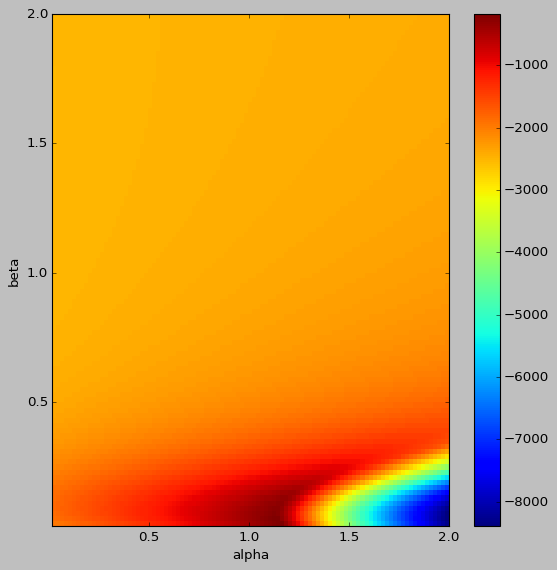

In [12]:
plt.style.use('classic')
fig = plt.figure(figsize=(8,8))
fig.tight_layout(pad=0.5)
plt.pcolor(XX, YY*amax/bmax,log_likelihood_values)
plt.xlim([np.min(XX), np.max(XX)])
plt.ylim([np.min(YY)*amax/bmax, np.max(YY)*amax/bmax])
plt.xlabel('alpha')
plt.ylabel('beta')
plt.colorbar()

In [47]:
fig = go.Figure(data=go.Heatmap(
                   z=log_likelihood_values.flatten(),
                   x=XX.flatten(),
                   y=(YY*amax/bmax).flatten(),
                   hoverongaps = False))
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

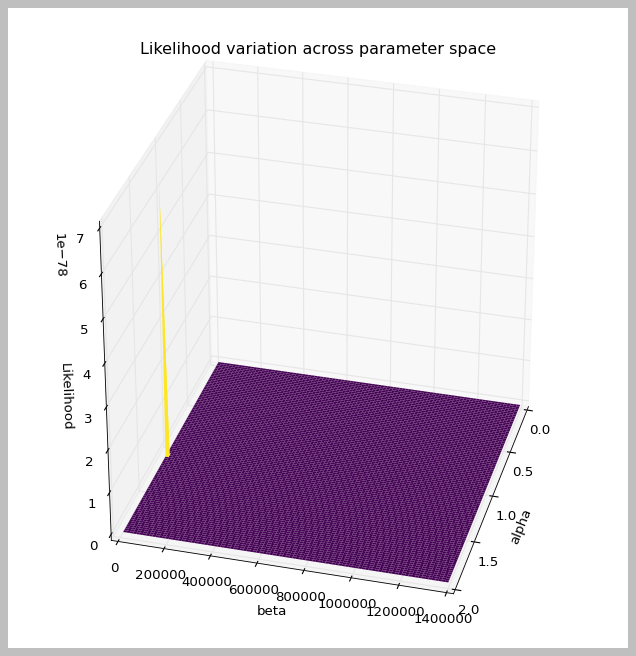

In [31]:
# 3D plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(XX, YY, np.exp(log_likelihood_values), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_ylabel("beta")
ax.set_xlabel("alpha")
ax.set_zlabel("Likelihood")
ax.set_title('Likelihood variation across parameter space')

ax.view_init(30, 15)

# Compute flows

In [75]:
if os.path.exists(f'../data/input/{dataset}/od_matrix.txt'):
    # Import flows
    T = np.loadtxt(f'../data/input/{dataset}/od_matrix.txt') #np.zeros((N,M))
    
# Initialise flows
That = np.zeros((N,M))

# Get best predictions
what = np.exp(minimize(log_likelihood, xd, method='L-BFGS-B', jac=True, args=(alpha,beta,global_minimum), options={'disp': False}).x)
xhat = np.log(what)

NameError: name 'global_minimum' is not defined

In [76]:
what

array([0.03015657, 0.0241917 , 0.01841066, 0.02907876, 0.01604904,
       0.01758076, 0.03838353, 0.02418289, 0.02883911, 0.01434237,
       0.0198653 , 0.02051189, 0.01846434, 0.01525237, 0.01477679,
       0.01943882, 0.01899288, 0.01527188, 0.03311571, 0.01439358,
       0.03075494, 0.01586492, 0.01600652, 0.01561084, 0.01698923,
       0.02485384, 0.01684926, 0.01613679, 0.01491106, 0.02945351,
       0.02585194, 0.02384034, 0.0226222 , 0.02190415, 0.01616545,
       0.01860322, 0.01571421, 0.01470041, 0.01467092, 0.01646127,
       0.02189221, 0.02236977, 0.01958359, 0.02255282, 0.01858532,
       0.01319311, 0.01816311, 0.01811137, 0.02627795])

In [68]:
np.exp(xd)

array([0.22593231, 0.04798297, 0.02779212, 0.04800045, 0.02077078,
       0.03506882, 0.02168368, 0.02018177, 0.03051473, 0.02076374,
       0.01968491, 0.04161963, 0.03315085, 0.02798188, 0.00772407,
       0.00902624, 0.01538141, 0.00919035, 0.00893432, 0.00923393,
       0.01284765, 0.00928523, 0.00944978, 0.00847378, 0.01179106,
       0.00997206, 0.00814897, 0.00787229, 0.00866603, 0.01073947,
       0.01116506, 0.01561587, 0.01937895, 0.01119434, 0.00879019,
       0.00617494, 0.01569963, 0.01566649, 0.00834758, 0.0073895 ,
       0.01061214, 0.01261658, 0.01341146, 0.01519074, 0.01164262,
       0.00956691, 0.01289441, 0.00810812, 0.00866921])

In [69]:
correlation_matrix = np.corrcoef(what, np.exp(xd))
correlation_xy = correlation_matrix[0,1]
print('Destination size R^2',correlation_xy**2)

Destination size R^2 0.09794343862819245


In [70]:
# Construct flow matrix
for i in range(N):
    for j in range(M):
        _sum = 0
        _sum_hat = 0 
        for jj in range(M):
            _sum += np.exp(alpha*xd[j]-beta*c[i,jj])
            _sum_hat += np.exp(XX[idx]*xhat[j]-YY[idx]*c[i,jj])
            
#         T[i,j] = o[i]*np.exp(alpha*xd[j]-beta*c[i,j]) / _sum
        
        That[i,j] = o[i]*np.exp(XX[idx]*xhat[j]-YY[idx]*c[i,j]) / _sum_hat

In [73]:
That

array([[3.30534206e-04, 6.79912044e-05, 1.71555174e-06, ...,
        7.29367367e-06, 1.41402015e-05, 2.23719756e-05],
       [6.70142933e-09, 1.57530063e-09, 3.43310359e-06, ...,
        9.88138854e-10, 6.50328656e-10, 4.61493662e-10],
       [2.63520602e-09, 5.22097960e-10, 2.19364535e-07, ...,
        1.57692233e-10, 1.45841970e-10, 1.80034031e-10],
       ...,
       [9.92179302e-04, 3.01284495e-04, 1.44165476e-07, ...,
        1.15218958e-05, 4.06726242e-05, 1.05626878e-04],
       [3.28478680e-05, 1.21351468e-04, 5.83208095e-09, ...,
        4.66872385e-06, 3.11937129e-05, 4.85344142e-04],
       [1.94541283e-03, 3.48243102e-04, 2.23737893e-07, ...,
        1.34214539e-05, 4.62625524e-05, 1.31260742e-04]])

In [267]:
T

array([[0.26107962, 0.03892039],
       [0.36345701, 0.13654299],
       [0.10273611, 0.09726389]])

In [72]:
np.sum(That,axis=0)

array([0.0290579 , 0.02486418, 0.01749284, 0.02655695, 0.01623772,
       0.01928522, 0.03427625, 0.02169503, 0.0295037 , 0.01338346,
       0.01880517, 0.01974527, 0.0172956 , 0.01515532, 0.01513219,
       0.02052978, 0.01805358, 0.01630307, 0.02917163, 0.01336961,
       0.03066983, 0.01585197, 0.01970653, 0.01509159, 0.01590959,
       0.02683211, 0.01858023, 0.01787197, 0.01575576, 0.0297509 ,
       0.02598404, 0.02325359, 0.02276942, 0.02252266, 0.018648  ,
       0.01847326, 0.01677694, 0.01484449, 0.01486758, 0.0177738 ,
       0.01998957, 0.02274187, 0.02006965, 0.02202012, 0.01985957,
       0.01496177, 0.01802978, 0.01879458, 0.02568432])

In [269]:
np.sum(T,axis=0)

array([0.72727273, 0.27272727])

In [270]:
np.sum((T-That)**2)

0.033979379201106795